імпортування бібліотек

In [1]:
import torch
import torch.nn as nn
import pathlib
from pathlib import Path
import shutil
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from timeit import default_timer as timer
import os
from typing import Tuple, Dict, List
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device agnostic code, тобто пишемо код одразу щоб можна було виконувати або cpu або gpu

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
train_dir = Path("/kaggle/input/muffin-vs-chihuahua/train")
test_dir = Path("/kaggle/input/muffin-vs-chihuahua/test")

функція для перегляду вмісту навчальної та тестової папок

In [4]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
print('TRAIN PATH TREE')
walk_through_dir(train_dir)
print('\nTEST PATH TREE')
walk_through_dir(test_dir)

TRAIN PATH TREE
There are 2 directories and 0 images in '/kaggle/input/muffin-vs-chihuahua/train'.
There are 0 directories and 2174 images in '/kaggle/input/muffin-vs-chihuahua/train/muffin'.
There are 0 directories and 2559 images in '/kaggle/input/muffin-vs-chihuahua/train/chihuahua'.

TEST PATH TREE
There are 2 directories and 0 images in '/kaggle/input/muffin-vs-chihuahua/test'.
There are 0 directories and 544 images in '/kaggle/input/muffin-vs-chihuahua/test/muffin'.
There are 0 directories and 640 images in '/kaggle/input/muffin-vs-chihuahua/test/chihuahua'.


візуалізація випадкового зображення з папки з навчальними даними

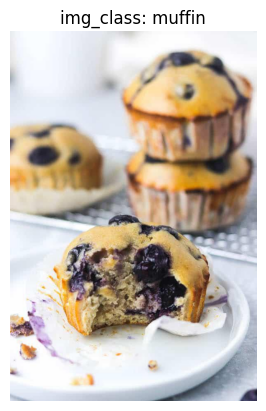

In [6]:
random.seed(42)
random_img_path = random.choice(list(train_dir.glob('*/*.jpg')))
img_class = random_img_path.parent.stem
img = Image.open(random_img_path)
img_as_arr = np.asarray(img)
plt.imshow(img_as_arr)
plt.title(f'img_class: {img_class}')
plt.axis(False);

в наступній клітинці задається послідовність перетворень, яка змінює розмір зображень до 256x256 пікселів і перетворює їх у тензори для подачі в модель

In [7]:
data_transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.ToTensor()
])

In [8]:
def plt_transformed_imgs(img_paths, transform, n=2, seed=1):
  random.seed(seed)
  random_img_path = random.sample(img_paths, k=n)
  for img_path in random_img_path:
    with Image.open(img_path) as f:
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f'original size: \n{f.size}')
      ax[0].axis(False)

      transformed_img = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_img)
      ax[1].set_title(f'transformed size: \n{transformed_img.shape}')
      ax[1].axis(False)

      fig.suptitle(img_path.parent.stem, fontsize = 16)

просто візуально порівнюємо розміри оригінального і зміненого зображення

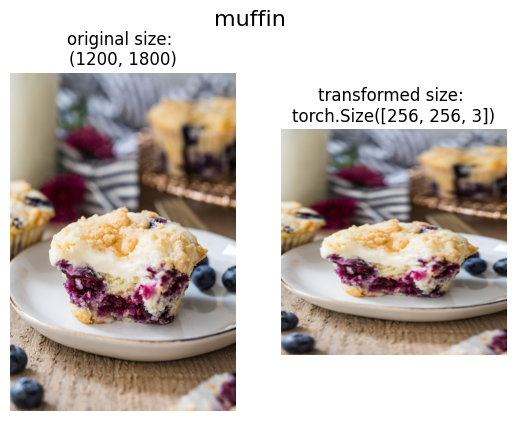

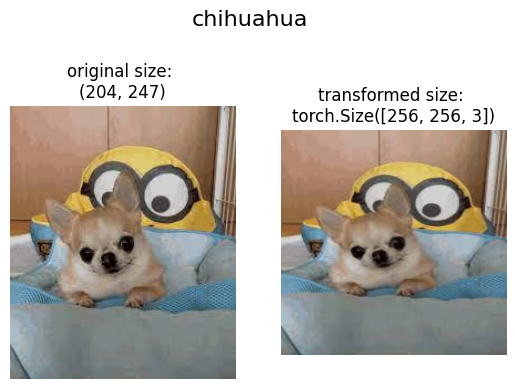

In [9]:
img_path_list = list(train_dir.glob('*/*.jpg'))
plt_transformed_imgs(img_path_list, transform = data_transform, n=2)

так як набір не поділено на навчальну-валідаційну-тестову вибірки, в лише на навчальну і тестову, то потрібно валідаційну виділити з навчальної (80% train, 20% validation)

In [10]:
random.seed(42)
work_dir = Path("/kaggle/working/muffin-vs-chihuahua")

train_dir_work = work_dir / "train"
val_dir = work_dir / "val"

if not work_dir.exists():
    shutil.copytree(train_dir, train_dir_work)

In [11]:
val_dir.mkdir(parents=True, exist_ok=True)

for class_dir in train_dir_work.iterdir():
    if class_dir.is_dir():
        (val_dir / class_dir.name).mkdir(parents=True, exist_ok=True)

In [12]:
split_ratio = 0.2

for class_dir in train_dir_work.iterdir():
    images = list(class_dir.glob("*"))
    random.shuffle(images)

    val_size = int(len(images) * split_ratio)
    val_images = images[:val_size]

    for img in val_images:
        shutil.move(
            img,
            val_dir / class_dir.name / img.name
        )

In [13]:
print("Train:", len(list(train_dir_work.rglob("*.jpg"))))
print("Val:", len(list(val_dir.rglob("*.jpg"))))
print("Test:", len(list(test_dir.rglob("*.jpg"))))

Train: 3788
Val: 945
Test: 1184


створюється три PyTorch-датасети (train, validation і test) з папок із зображеннями, автоматично визначаючи класи за назвами підпапок та застосовуючи задані перетворення до кожного зображення

In [14]:
train_data = datasets.ImageFolder(root=train_dir_work,
                                  transform=data_transform,
                                  target_transform=None)

val_data = datasets.ImageFolder(root=val_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)

print(f'TRAIN {train_data}\nVAL {val_data}\nTEST {test_data}')

TRAIN Dataset ImageFolder
    Number of datapoints: 3788
    Root location: /kaggle/working/muffin-vs-chihuahua/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
VAL Dataset ImageFolder
    Number of datapoints: 945
    Root location: /kaggle/working/muffin-vs-chihuahua/val
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
TEST Dataset ImageFolder
    Number of datapoints: 1184
    Root location: /kaggle/input/muffin-vs-chihuahua/test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [15]:
class_names = train_data.classes
class_names

['chihuahua', 'muffin']

Створюємо три DataLoaders для тренувального, валідаційного та тестового датасетів, які подають дані батчами по 32 зображення

In [16]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              num_workers=os.cpu_count(),
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_data,
                              batch_size=32,
                              num_workers=os.cpu_count(),
                              shuffle=False)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=32,
                              num_workers=os.cpu_count(),
                              shuffle=False)

train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a6a58509670>,
 <torch.utils.data.dataloader.DataLoader at 0x7a6a5850a5d0>)

Створення згорткової нейронної мережі

In [17]:
class SimpleModel(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape, out_channels = 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_block_4 = nn.Sequential(
        nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 1024*16*16,
                  out_features = output_shape)
    )

  def forward(self, x:torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.conv_block_3(x)
    x = self.conv_block_4(x)
    x = self.classifier(x)
    return x

In [38]:
torch.manual_seed(42)
model_0 = SimpleModel(input_shape=3, hidden_units=50, output_shape=len(train_data.classes)).to(device)
model_0

SimpleModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride

Створимо клас для зупинки навчання моделі для уникнення перенавчання за принципом early stopping

In [19]:
class EarlyStopping:
    def __init__(self, patience = 5, min_delta = 0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.loss = None
        self.early_stopping = False

    def __call__(self, val_loss):
        if self.loss is None:
            self.loss = val_loss
        elif self.loss - val_loss > self.min_delta:
            self.loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stopping = True

функція, що виконує один епох навчання моделі, проходячи по батчах даталодера, обчислюючи втрати та точність, виконуючи зворотне поширення помилки й оновлення ваг, і повертає середні значення loss та accuracy за епоху

In [20]:
def train_loop(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim = 1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

функція, що переводить модель у режим оцінювання та проходить по валідаційному даталодеру, обчислюючи середні значення втрат і точності без оновлення ваг моделі

In [21]:
def val_loop(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
  model.eval()
  val_loss, val_acc = 0, 0

  with torch.inference_mode():
      for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred_log = model(X)
        loss = loss_fn(y_pred_log, y)
        val_loss += loss.item()
    
        y_pred_class = y_pred_log.argmax(dim = 1)
        val_acc += (y_pred_class == y).sum().item() / len(y_pred_class)

  val_loss = val_loss / len(dataloader)
  val_acc = val_acc / len(dataloader)
  return val_loss, val_acc

функція, що керує повним процесом навчання моделі протягом заданої кількості епох

In [22]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 5,
          epochs_step_for_print: int = 1):
    
  results = {"train_loss" : [],
             "train_acc" : [],
             "val_loss" : [],
             "val_acc" : []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_loop(model=model_0,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    val_loss, val_acc = val_loop(model=model_0,
                                       dataloader=val_dataloader,
                                       loss_fn=loss_fn)

    if (epoch + 1) % epochs_step_for_print == 0:
        print(f"epoch: {epoch+1} |"
        f'train_loss: {train_loss:.4f} |'
        f'train_acc: {train_acc:.4f} |'
        f'val_loss: {val_loss:.4f} |'
        f'val_acc: {val_acc:.4f}')

    if early_stop is not None:
        early_stop(val_loss)
        if early_stop.early_stopping:
            print(f"Stopped at {epoch+1} epoch")
            break

    results['train_loss'].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results['train_acc'].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results['val_loss'].append(val_loss.item() if isinstance(val_loss, torch.Tensor) else val_loss)
    results['val_acc'].append(val_acc.item() if isinstance(val_acc, torch.Tensor) else val_acc)


  return results


навчання моделі

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 100
early_stop = EarlyStopping(patience = 15, min_delta = 0.001)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.001)

start_timer = timer()

model_0_results = train(model = model_0,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=epochs,
                        epochs_step_for_print = 1)
end_time = timer()
print(f'\nTOTAL TIME: {(end_time - start_timer)/60:.4f} minutes')

  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 1 |train_loss: 0.7753 |train_acc: 0.5392 |val_loss: 0.6892 |val_acc: 0.5323
epoch: 2 |train_loss: 0.5944 |train_acc: 0.6839 |val_loss: 0.4254 |val_acc: 0.8118
epoch: 3 |train_loss: 0.4229 |train_acc: 0.8196 |val_loss: 0.3859 |val_acc: 0.8402
epoch: 4 |train_loss: 0.3648 |train_acc: 0.8430 |val_loss: 0.4083 |val_acc: 0.8305
epoch: 5 |train_loss: 0.3347 |train_acc: 0.8575 |val_loss: 0.3456 |val_acc: 0.8588
epoch: 6 |train_loss: 0.2971 |train_acc: 0.8824 |val_loss: 0.3098 |val_acc: 0.8725
epoch: 7 |train_loss: 0.2800 |train_acc: 0.8884 |val_loss: 0.3365 |val_acc: 0.8793
epoch: 8 |train_loss: 0.2502 |train_acc: 0.9008 |val_loss: 0.2624 |val_acc: 0.9066
epoch: 9 |train_loss: 0.2550 |train_acc: 0.8998 |val_loss: 0.3356 |val_acc: 0.8815
epoch: 10 |train_loss: 0.2215 |train_acc: 0.9131 |val_loss: 0.2877 |val_acc: 0.8880
epoch: 11 |train_loss: 0.2056 |train_acc: 0.9209 |val_loss: 0.3053 |val_acc: 0.8952
epoch: 12 |train_loss: 0.1811 |train_acc: 0.9355 |val_loss: 0.3048 |val_acc: 0.8879
e

будуємо функцію втрат і accuracy на графіку

In [24]:
def plt_loss_curves(results: Dict[str, List[float]]):
  train_loss = results['train_loss']
  val_loss = results['val_loss']
  train_acc = results['train_acc']
  val_acc = results['val_acc']

  epochs = range(len(results['val_loss']))

  plt.figure(figsize=(15,7))

  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label='train_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, train_acc, label='train_accuracy')
  plt.plot(epochs, val_acc, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('Epochs')
  plt.legend();

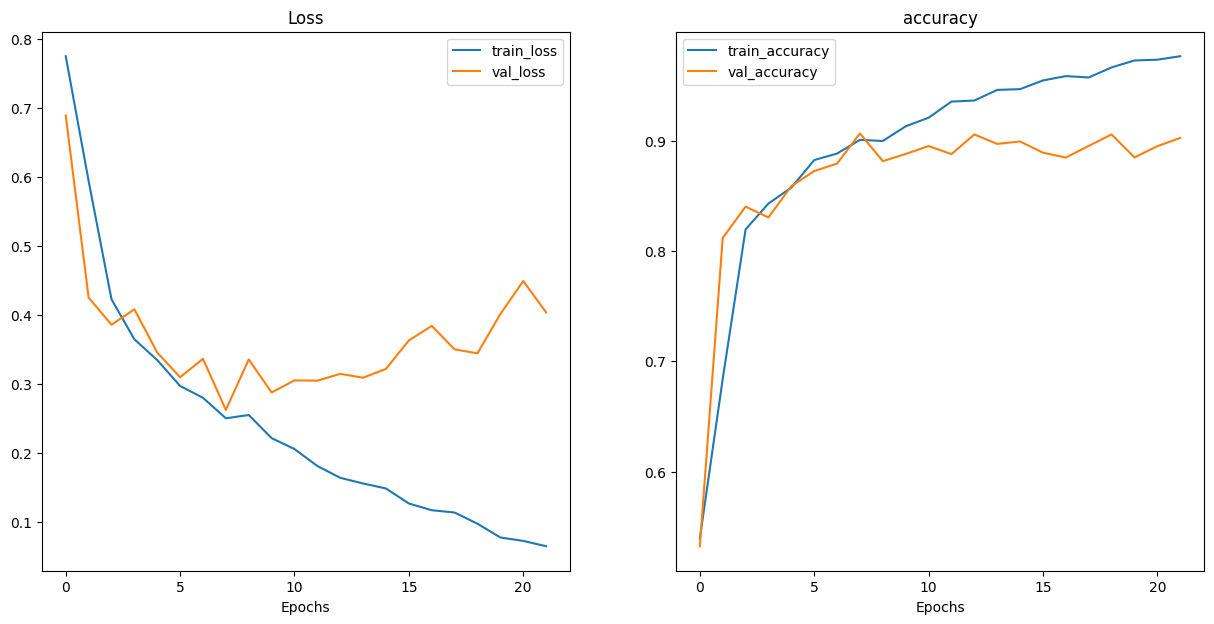

In [40]:
plt_loss_curves(results=model_0_results)

перенавчаємо модель на повному навчальному наборі даних

In [27]:
train_val_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

train_val_dataloader = DataLoader(dataset=train_val_data,
                              batch_size=32,
                              num_workers=os.cpu_count(),
                              shuffle=True)

In [28]:
train_val_data

Dataset ImageFolder
    Number of datapoints: 4733
    Root location: /kaggle/input/muffin-vs-chihuahua/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [29]:
def train_final(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 5):
    
  results = {"train_loss" : [],
             "train_acc" : []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_loop(model=model_0,
                                       dataloader=train_val_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)

    print(f"epoch: {epoch+1} |"
    f'train_loss: {train_loss:.4f} |'
    f'train_acc: {train_acc:.4f} |')

    results['train_loss'].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results['train_acc'].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)

  return results


In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.001)

start_timer = timer()

model_0_results = train_final(model = model_0,
                        train_dataloader=train_val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=epochs)
end_time = timer()
print(f'\nTOTAL TIME: {(end_time - start_timer)/60:.4f} minutes')

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 1 |train_loss: 0.7221 |train_acc: 0.5249 |
epoch: 2 |train_loss: 0.5527 |train_acc: 0.7201 |
epoch: 3 |train_loss: 0.3879 |train_acc: 0.8394 |
epoch: 4 |train_loss: 0.3362 |train_acc: 0.8633 |
epoch: 5 |train_loss: 0.3232 |train_acc: 0.8696 |
epoch: 6 |train_loss: 0.2997 |train_acc: 0.8786 |
epoch: 7 |train_loss: 0.2678 |train_acc: 0.8950 |
epoch: 8 |train_loss: 0.2553 |train_acc: 0.8985 |
epoch: 9 |train_loss: 0.2596 |train_acc: 0.8952 |
epoch: 10 |train_loss: 0.2299 |train_acc: 0.9121 |
epoch: 11 |train_loss: 0.1928 |train_acc: 0.9313 |
epoch: 12 |train_loss: 0.1765 |train_acc: 0.9330 |
epoch: 13 |train_loss: 0.1609 |train_acc: 0.9400 |
epoch: 14 |train_loss: 0.1501 |train_acc: 0.9440 |
epoch: 15 |train_loss: 0.1140 |train_acc: 0.9602 |
epoch: 16 |train_loss: 0.1017 |train_acc: 0.9649 |
epoch: 17 |train_loss: 0.0733 |train_acc: 0.9759 |
epoch: 18 |train_loss: 0.0741 |train_acc: 0.9757 |
epoch: 19 |train_loss: 0.0578 |train_acc: 0.9816 |
epoch: 20 |train_loss: 0.0712 |train_acc

перевірка якості створеної моделі на тестовому наборі

In [31]:
true_samples = []
pred_samples = []

model_0.eval()
test_acc = 0
with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
      X, y = X.to(device), y.to(device)
      y_pred_log = model_0(X)
      y_pred_class = y_pred_log.argmax(dim = 1)

      true_samples.extend(y.cpu().numpy())
      pred_samples.extend(y_pred_class.cpu().numpy())
        
      test_acc += (y_pred_class == y).sum().item() / len(y_pred_class)

test_acc = test_acc / len(test_dataloader)
test_acc

0.879222972972973

будуємо confusion_matrix

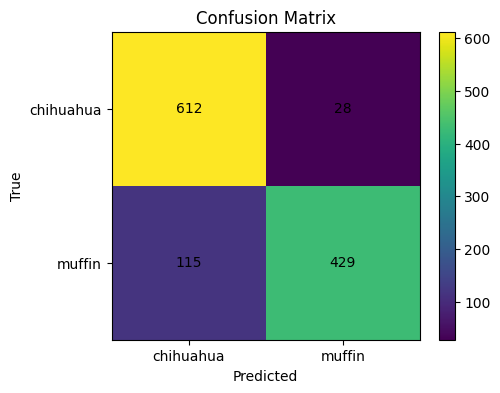

In [32]:
cm = confusion_matrix(true_samples, pred_samples)
plt.figure(figsize=(5, 4))
plt.imshow(cm)
plt.colorbar()

plt.xticks(range(len(class_names)), class_names)
plt.yticks(range(len(class_names)), class_names)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i, j], ha="center", va="center")

обчислюємо та виводимо classification report, який показує precision, recall, F1-score і support для кожного класу на основі справжніх та передбачених міток

In [33]:
cr = classification_report(true_samples, pred_samples, 
                           target_names=class_names, zero_division=0)
print(f'Classification Report:\n {cr}')

Classification Report:
               precision    recall  f1-score   support

   chihuahua       0.84      0.96      0.90       640
      muffin       0.94      0.79      0.86       544

    accuracy                           0.88      1184
   macro avg       0.89      0.87      0.88      1184
weighted avg       0.89      0.88      0.88      1184



Трохи візуалізації прогнозів

In [34]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
            
    return torch.stack(pred_probs)

In [35]:
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([3, 256, 256])
Test sample label: 0 (chihuahua)


In [36]:
pred_probs= make_predictions(model=model_0, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)
test_labels, pred_classes

([0, 0, 0, 0, 0, 0, 0, 1, 0], tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]))

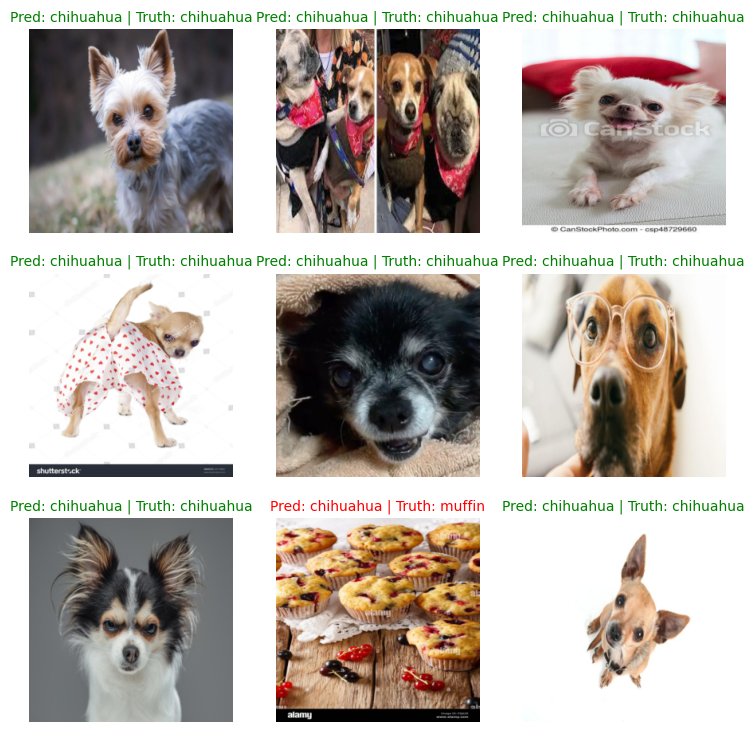

In [37]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.permute(1, 2, 0))
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]] 
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g")
  else:
      plt.title(title_text, fontsize=10, c="r")
  plt.axis(False);